# Trace Veloce Spectra

Steps:
1. detect and measure bias overscan
2. remove gaps
3. detect flux through thresholding to get initial trace for each order
   - flux for one row -> get threshold (medfiltr1())
   - result pixels belonging to orders, this can be done on flats
   - background vs order detection - iterative approach 
   - average in x direction, and fit the polynomial 
4. smooth the trace
5. work out summing range

In [1]:
from astropy.io import fits
import os
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import median_filter

# from csaps import csaps

from cv2 import merge

In [2]:
import veloce_reduction_tools

In [3]:
# %config IPython.matplotlib.backend = "retina"
# from matplotlib import rcParams
# rcParams["figure.dpi"] = 150
# rcParams["savefig.dpi"] = 150
# rcParams["xtick.direction"] = "in"
# rcParams["ytick.direction"] = "in"
# rcParams["xtick.top"] = True
# rcParams["ytick.right"] = True
# rcParams["font.size"] = 14

# # rcParams['axes.left'] = False
# # rcParams['axes.right'] = False
# # rcParams['axes.top'] = False
# # rcParams['axes.bottom'] = False

### Load Flat

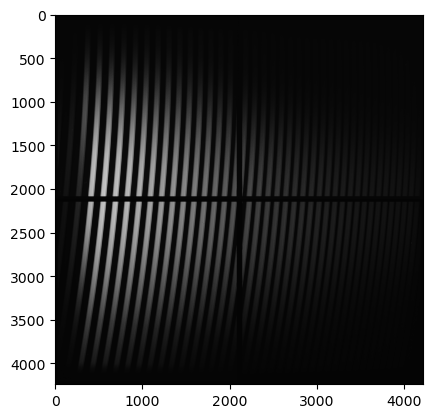

In [3]:
filename = '24aug20010.fits' # use the flat because of visibility
spectrum_filename =  os.path.join(os.getcwd(), 'Data', filename)

image_data = fits.getdata(spectrum_filename)
plt.imshow(image_data, cmap='gray', norm="log")

In [5]:
# %matplotlib qt
# ylen, xlen = image_data.shape
# xdiv, ydiv = int(xlen/2), int(ylen/2)

# plt.imshow(image_data, cmap='gray', norm="log")
# plt.axline([xdiv,0], [xdiv,ylen], c='r')
# plt.axline([0,ydiv], [xlen,ydiv], c='y')
# plt.xlim(0,xlen)
# plt.ylim(0,ylen)
# plt.colorbar()

### 1. Measure bias overscan and remove gaps

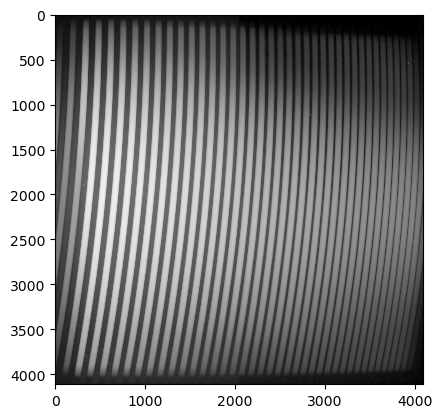

In [4]:
image_substracted_bias = veloce_reduction_tools.remove_overscan_bias(image_data, overscan_range=32)

plt.imshow(image_substracted_bias, cmap='gray', norm="log")

In [7]:
''' 
shape is consistent with info from manual 
but there is a row of 'bias' pixels at the bottom of the image
'''

image_substracted_bias.shape 

(4112, 4096)

### 2. Detect flux through thresholding to get initial trace for each order

In [5]:
# blured = cv2.blur(image_substracted_bias, (10,10), cv2.BORDER_DEFAULT) 
blured = median_filter(image_substracted_bias, (10,10))
# plt.imshow(blured, cmap='gray', norm='log')

flux from one row -> get threshold (medfiltr1())

In [9]:
# %matplotlib qt
# frame = blured
# xlen, ylen = frame.shape

# row = 50
# x = np.arange(len(frame[row,:]))
# threshold = median_filter(frame[row,:],501) + 1
# noise_std = np.std(frame[row,:][frame[row,:]<threshold])
# plt.step(x, threshold)
# plt.step(x, frame[row,:])
# plt.axline([0,5*noise_std], [1000,5*noise_std])
# plt.axline([0,abs(np.mean(frame[row,:])-np.median(frame[row,:]))], [1000,abs(np.mean(frame[row,:])-np.median(frame[row,:]))], c='r')
# plt.axline([0,max(frame[row,:])-min(frame[row,:])], [1000,max(frame[row,:])-min(frame[row,:])], c='y')
# plt.axline([0,np.mean(frame[row,:])], [1000,np.mean(frame[row,:])], c='g')
# plt.axline([0,np.median(frame[row,:])], [1000,np.median(frame[row,:])], c='g')

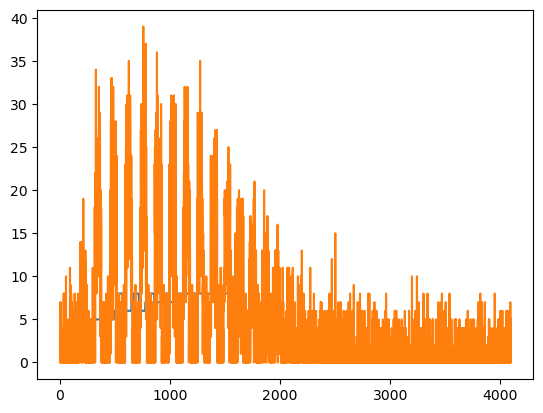

In [6]:
n = 150
# plot_cross_section(blured, n, axis='x')
veloce_reduction_tools.plot_cross_section(image_substracted_bias, n, axis='x')

# fig, ax = plt.subplots(figsize=(12,6))
# ax.set_title('flat_cross_section')
# ax.set_xlabel('x [pix]')
# ax.set_ylabel('flux')
# x = np.arange(len(blured[n,:]))
# threshold = median_filter(blured[n,:],501)
# ax.plot(x, threshold)
# ax.step(x, blured[n,:])
# plt.tight_layout()
# plt.savefig('flat_cross_section.png')

result pixels belonging to orders, this can be done on flats.

Switched to threshold detected per row, as median filter with wide span

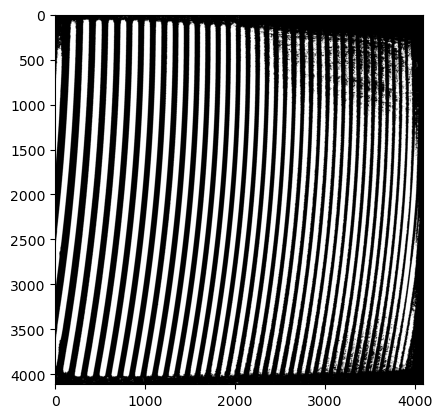

In [7]:
binarized = veloce_reduction_tools.get_binary_mask(blured, axis='x')
# binarized = veloce_reduction_tools.get_binary_mask(image_substracted_bias, axis='x')

plt.imshow(binarized, cmap='gray')

maybe even better on master flat?

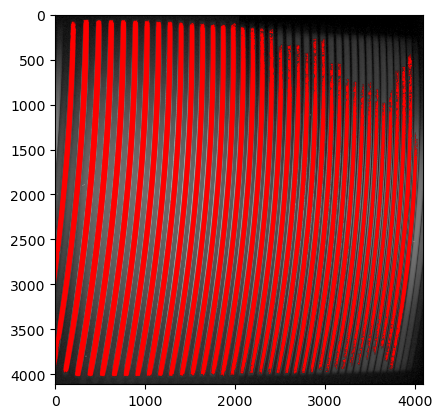

In [8]:
orders = veloce_reduction_tools.get_orders_masks(binarized)

img_orders = merge([255*np.sum(orders, axis=0),
                        0*np.sum(orders, axis=0),
                        0*np.sum(orders, axis=0),
                        255*np.sum(orders, axis=0)]) # from cv2
plt.imshow(image_substracted_bias, cmap='gray', norm='log')
plt.imshow(img_orders)

In [13]:
### to check if orders are seperated 
# %matplotlib inline

# for order in orders:
#     img_order = merge([255*order, 0*order, 0*order, 255*order])
#     plt.imshow(image_substracted_bias, cmap='gray', norm='log')
#     plt.imshow(img_order)
#     plt.show()

### 3. get and smooth the trace

average in x direction, and fit the polynomial

TO DO: fit higher order polynomial and don't use rows with incomplite order

In [9]:
traces = veloce_reduction_tools.get_traces(image_substracted_bias, orders)

In [15]:
# ylen, xlen = frame.shape
# plt.imshow(frame, cmap='gray', norm='log', aspect='equal')
# plt.imshow(img_orders)
# for fitted_trace in fitted_traces:
#     plt.plot(fitted_trace[0], fitted_trace[1], c='b')
# # plt.xlim(0,xlen)

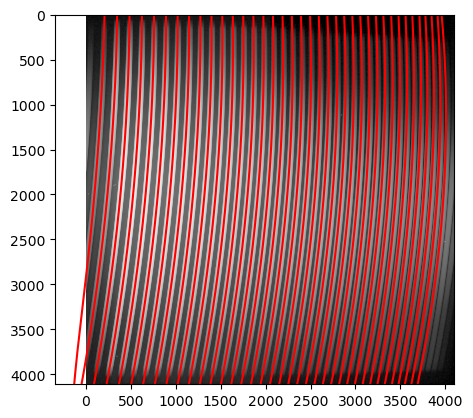

In [10]:
# %matplotlib widget

plt.imshow(image_substracted_bias, cmap='gray', norm='log', aspect='equal')
y = np.arange(len(image_substracted_bias[:,0]))
for trace in traces:
    plt.plot(trace, y, c='r')
# for trace in traces_2:
#     plt.plot(trace, y, c='g')
# plt.xlim(0,xlen)

### 4. Work out summing range

array([[ 3.,  2.,  2., ...,  0.,  0.,  0.],
       [ 1.,  4.,  4., ...,  1.,  2.,  5.],
       [ 0.,  4.,  0., ...,  0.,  3.,  5.],
       ...,
       [ 0.,  6.,  4., ...,  6.,  4.,  0.],
       [ 4., 10.,  4., ...,  4.,  2.,  0.],
       [ 2.,  0.,  3., ...,  5.,  1.,  0.]])

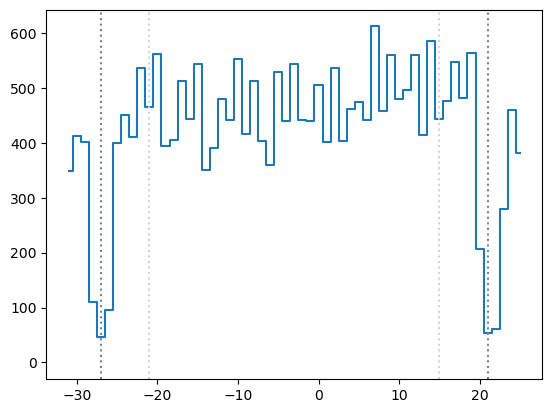

In [15]:
veloce_reduction_tools.plot_order_cross_section(image_substracted_bias, traces, (26, 20), 10)

In [18]:
summing_ranges = veloce_reduction_tools.find_summing_range(blured, traces)

In [19]:
extracted_orders = veloce_reduction_tools.extract_orders(image_substracted_bias, traces, summing_ranges)

[21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21.
 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21.
 21. 21. 21. 21.]


(0.0, 4096.0)

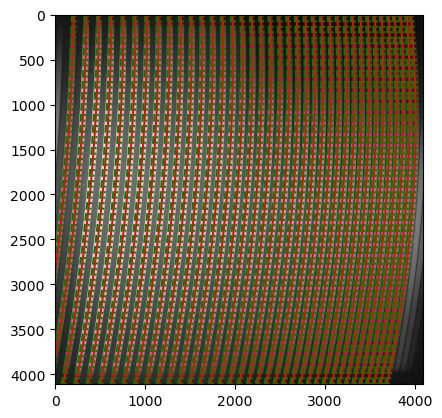

In [62]:
# %matplotlib qt
frame = image_substracted_bias.copy()
ylen, xlen = frame.shape
plt.imshow(frame, cmap='gray', norm='log', aspect='equal')
print(str(summing_ranges))
for trace, summing_range in zip(traces, summing_ranges):
    plt.plot(trace,y, c='r')
    plt.plot(trace+summing_range,y, ls=':', c='g')
    plt.plot(trace-summing_range,y, ls='--', c='g')
plt.xlim(0,xlen)

In [66]:
summing_ranges = np.ones(len(traces))*21

In [67]:
blazes = veloce_reduction_tools.extract_orders_with_trace(image_substracted_bias, traces, summing_ranges)

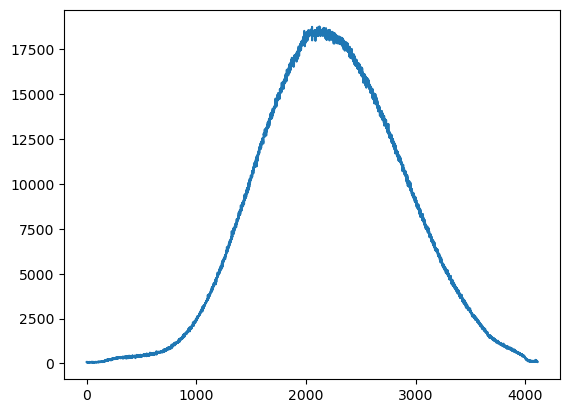

In [71]:
plt.plot(blazes[18])

In [24]:
# traces=traces[:-1]
# summing_ranges=summing_ranges[:-1]
# extracted_orders=extracted_orders[:-1]

In [72]:
np.savez('veloce_trace_green', traces=traces, summing_ranges=summing_ranges)

In [73]:
np.savez('veloce_blaze_green_pix', blazes=blazes)

In [27]:
# trace_data = np.load('veloce_trace_red.npz')
# traces, summing_ranges = trace_data['traces'], trace_data['summing_ranges']
# traces, summing_ranges